# Thermal equilibrium of interacting dimer


In this notebook we simulate the thermal equilibrium (Boltzmann distrubion) of two interacting magnetic nanoparticles (dimer), coupled with dipolar interactions. The equilibrium distribution is computed with three different approaches
 - Analytic solution is computed by hand (easy for two aligned particles)
 - Markov chain Monte-Carlo (MCMC) sampling of the energy functions using PyMC3
 - Simulating the stochastic Landau-Lifshitz-Gilbert equation until equilibrium using magpy
 

## Setup

Two particles are aligned along their anisotropy axes at a distance of $R$. They have identical volume $V$, anisotropy constant $K$, saturation magnetisation $M_s$. The temperature of the environment is $T$. The angle of the magnetic moment to the anisotropy axis is $\theta_1,\theta_2$ for particle 1 and 2 respectively.

![dimer](https://docs.google.com/drawings/d/1ljdYNWVgGOyGHJ5oRQp3_yOSHNxW7Kqkcp16TBl7xYw/pub?w=415&h=123)

## Analytic solution

The **solid angle** of the magnetisation angles follow a Boltzmann distribution, such that the angle $\theta$ is distributed:


$$p\left(\theta_1,\theta_2\right) = \frac{\sin(\theta_1)\sin(\theta_2)e^{-E\left(\theta_1,\theta_2\right)/\left(K_BT\right)}}{Z}$$

where

$$\frac{E\left(\theta_1,\theta_2\right)}{K_BT}=\sigma\left(\cos^2\theta_1+\cos^2\theta_2\right)
-\nu\left(3\cos\theta_1\cos\theta_2 - \cos\left(\theta_1-\theta_2\right)\right)$$

$$\sigma=\frac{KV}{K_BT}$$

$$\nu=\frac{\mu_0V^2M_s^2}{2\pi R^3K_BT}$$

$\sigma,\nu$ are the normalised anisotropy and interaction strength respectively.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

Individual energy terms

In [2]:
def dd(t1, t2, nu):
    return -nu*(3*np.cos(t1)*np.cos(t2) - np.cos(t1-t2))
def anis(t1, t2, sigma):
    return sigma*(np.sin(t1)**2 + np.sin(t2)**2)
def tot(t1, t2, nu, sigma):
    return dd(t1, t2, nu) + anis(t1, t2, sigma)

The unnormalised probability of state $\theta_1\theta_2$

In [3]:
def p_unorm(t1,t2,nu,sigma):
    return np.sin(t1)*np.sin(t2)*np.exp(-tot(t1,t2,nu,sigma))

2-dimensional Boltzmann distribution

In [4]:
from scipy.integrate import dblquad
def boltz_2d(ts, nu, sigma):
    e = np.array([[p_unorm(t1,t2,nu,sigma) for t1 in ts] for t2 in ts])
    Z = dblquad(lambda t1,t2: p_unorm(t1,t2,nu,sigma),
                0, ts[-1], lambda x: 0, lambda x: ts[-1])[0]

    return e/Z

## Analytical results

We show resulting calculations for the following three cases:
 - No interactions
 - Strong interactions
 - Strong interactions and weak anisotropy

In [5]:
nus = [0, 0.3, 0.3]
sigmas = [2.0, 2.0, 0.5]

### Energy landscape

The plots below show the energy associated with each point of the 2-dimensional phase space (i.e. one angle per particle). Low energy (purple) states are energetically favourable wherea the high energy states (yellow) are not.

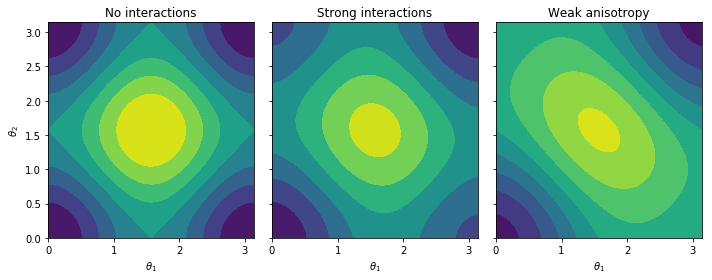

In [6]:
ts = np.linspace(0, np.pi, 100)
fg, axs = plt.subplots(1, 3, figsize=(10,4), sharey=True)
for nu, sigma, ax in zip(nus, sigmas, axs):
    e = [[tot(t1, t2, nu, sigma) for t1 in ts] for t2 in ts]
    cf = ax.contourf(ts, ts, e)
    ax.set_xlabel('$\\theta_1$')
axs[0].set_title('No interactions')
axs[0].set_ylabel('$\\theta_2$')
axs[1].set_title('Strong interactions')
axs[2].set_title('Weak anisotropy')
plt.tight_layout();

### Probability state-space

The probability of each point in the phase space is directily related to the energy through the Boltzmann distribution (above). The three different cases are described:
 - With no interactions, the probability space is symetrical since both variables are identically distibuted and independent of one another. Both particle are much more likely to be found close to the anisotropy axis (either parallel or antiparallel).
 - With interactions, the symmetry is broken and the particles prefer to be aligned with the anisotropy axis and one another. This increases the probability of the system being in aligned states around the axes rather.
 - With weak anisotropy, the particles prefer to be aligned with one another but are less likely to be found near the anisotropy axis.

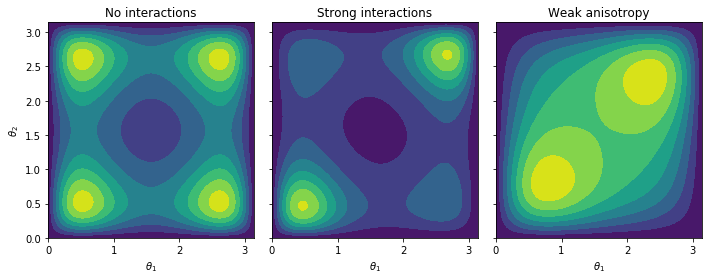

In [7]:
ts = np.linspace(0, np.pi, 100)
fg, axs = plt.subplots(1, 3, figsize=(10,4), sharey=True)
for nu, sigma, ax in zip(nus, sigmas, axs):
    b = boltz_2d(ts, nu, sigma)
    cf=ax.contourf(ts, ts, b)
    ax.set_xlabel('$\\theta_1$')
axs[0].set_title('No interactions')
axs[0].set_ylabel('$\\theta_2$')
axs[1].set_title('Strong interactions')
axs[2].set_title('Weak anisotropy')
plt.tight_layout();

## Markov-chain Monte-Carlo (MCMC)

Computing the analytic solutions required the partition function $Z$ to be computed, which was achieved with numerical integration. For more than 2 particles this becomes extremely difficult. A more efficient approach is to use MCMC. In MCMC we randomly choose a system state and add it to a histogram depending on how energetically favourable the state is. The more states we try, the closer our histogram becomes to the true distribution.

We use PyMC3 for MCMC sampling. The model is simple:

 - We sample uniformly on the unit sphere (i.e. draw solid angles uniformly), converting into the angle $\theta_1$ and $\theta_2$
 - We compute the energy for both particles
 - We pass this energy to PyMC3
 
PyMC3 uses the NUTS algorithm to efficicently sample trial states with a high acceptance rate.

In [8]:
import pymc3 as pm

Setting up the PyMC3 model is simple! Specify the priors and the energy function using `pm.Potential`

In [9]:
from theano import tensor as tt
def tt_tot(t1, t2, nu, sigma):
    dd = -nu*(3*tt.cos(t1)*tt.cos(t2) - tt.cos(t1-t2))
    anis = sigma*(tt.sin(t1)**2 + tt.sin(t2)**2)
    return dd+anis

In [10]:
nu = 0.3
sigma = 1.5

with pm.Model() as model:
    z1 = pm.Uniform('z1', -1, 1)
    theta1 = pm.Deterministic('theta1', np.arccos(z1))
    z2 = pm.Uniform('z2', -1, 1)
    theta2 = pm.Deterministic('theta2', np.arccos(z2))
    
    energy = tt_tot(theta1, theta2, nu, sigma)
    
    like = pm.Potential('energy', -energy)

Chose the NUTS algorithm as our MCMC step and request a large number of random samples. These are returned in the `trace` variable.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 99%|█████████▉| 10396/10500 [00:07<00:00, 1520.27it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 3 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 10500/10500 [00:07<00:00, 1373.15it/s]


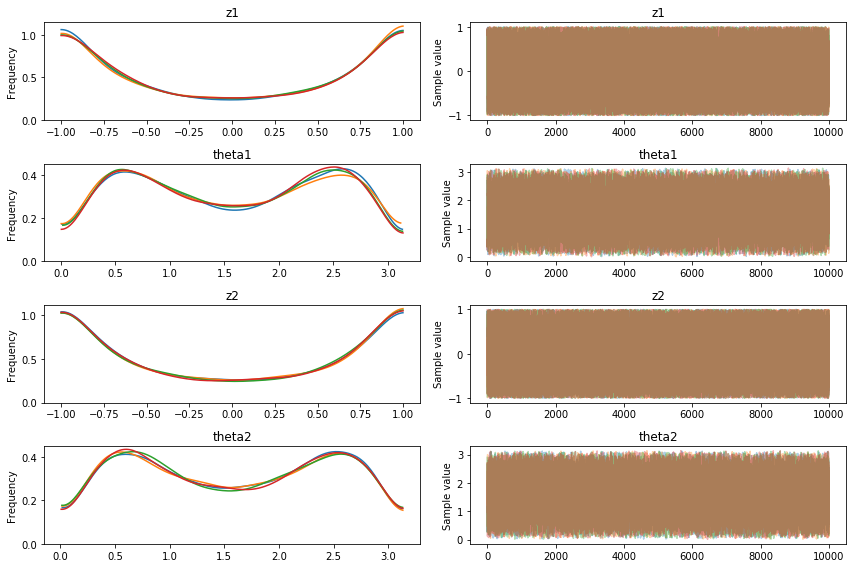

In [16]:
with model:
    trace = pm.sample(10000, njobs=4)
pm.traceplot(trace);

### Compare results

The `trace` contains a large number of samples of the system states. The distribution (histogram) over this large sample of states should be close to the true distribution. We can compare the 2D histogram of the system angles to the analytic solution we computed previously. 

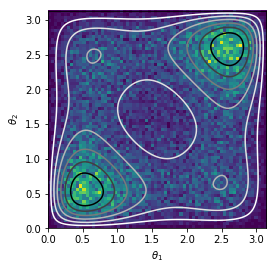

In [17]:
b = boltz_2d(ts, nu, sigma)
plt.hist2d(trace['theta1'], trace['theta2'], bins=70, normed=True)
# plt.scatter(trace['theta1'], trace['theta2'], alpha=.05)
plt.contour(ts, ts, b, cmap='Greys')
plt.gca().set_aspect('equal')
plt.xlabel('$\\theta_1$'); plt.ylabel('$\\theta_2$');

### Marginalisation over one variable

The results look good! We can also check that the marginal distributions of the two angles are correct. The marginal distributions are also easier to check by eye.

$$p(\theta_1) = \int p(\theta_1, \theta_2) \mathrm{d}\theta_2$$
$$p(\theta_2) = \int p(\theta_1, \theta_2) \mathrm{d}\theta_1$$

In [18]:
from scipy.integrate import trapz
b_marginal = -b.sum(axis=0) / trapz(ts, b.sum(axis=0))

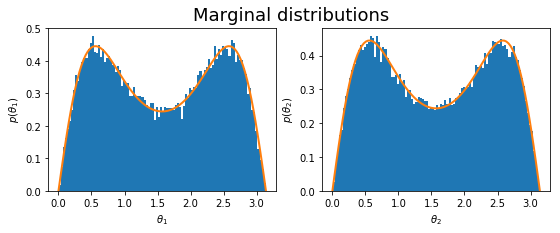

In [19]:
fg, axs = plt.subplots(ncols=2, figsize=(9,3))
for i in range(2):
    axs[i].hist(trace['theta{}'.format(i+1)], bins=100, normed=True)
    axs[i].plot(ts, b_marginal, lw=2)
    axs[i].set_xlabel('$\\theta_{}$'.format(i+1))
    axs[i].set_ylabel('$p(\\theta_{})$'.format(i+1))
plt.suptitle('Marginal distributions', fontsize=18);